In [1]:
import pickle
with open('train.pickle', 'rb') as f:
    train = pickle.load(f)

In [2]:
with open('valid.pickle', 'rb') as f:
    valid = pickle.load(f)

In [3]:
with open('test.pickle', 'rb') as f:
    test = pickle.load(f)

In [4]:
import pandas as pd

In [5]:
import string
import re

In [6]:
def preprocess(text):
    #小文字にする
    text = text.lower()
    #記号を取り除く
    code_regex = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]')
    text = code_regex.sub('', text)
    #数字を全部0に
    text = re.sub('[0-9]+', '0', text)
    return text

In [7]:
train['TITLE'] = train['TITLE'].map(lambda x: preprocess(x))
train.reset_index(drop=True, inplace=True)
train

,TITLE,CATEGORY
0,refileupdate 0european car sales up for sixth ...,b
1,amazon plans to fight ftc over mobileapp purch...,t
2,kids still get codeine in emergency rooms desp...,m
3,what on earth happened between solange and jay...,e
4,nato missile defense is flight tested over hawaii,b
...,...,...
10679,the pillow book of tim geithner,b
10680,robin thicke spends 0 on amethyst stone at cry...,e
10681,japanese shares little changed after biggest r...,b
10682,wrapup 0liberia shuts schools as ebola spreads...,m


In [8]:
valid['TITLE'] = valid['TITLE'].map(lambda x: preprocess(x))
valid.reset_index(drop=True, inplace=True)

In [9]:
test['TITLE'] = test['TITLE'].map(lambda x: preprocess(x))
test.reset_index(drop=True, inplace=True)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.8)
X_train = vectorizer.fit_transform(train['TITLE'])
X_valid = vectorizer.transform(valid['TITLE'])
X_test = vectorizer.transform(test['TITLE'])
X_train = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
X_valid = pd.DataFrame(X_valid.toarray(), columns=vectorizer.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names())

In [12]:
X_train.to_csv('./train.features.txt', sep='\t', index=False)
X_valid.to_csv('./valid.features.txt', sep='\t', index=False)
X_test.to_csv('./test.features.txt', sep='\t', index=False)

In [13]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=123, max_iter=10000)
lg.fit(X_train, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=123)

In [14]:
import numpy as np

def score_lg(lg, X):
  return [np.max(lg.predict_proba(X), axis=1), lg.predict(X)]

In [15]:
train_pred = score_lg(lg, X_train)
test_pred = score_lg(lg, X_test)

print(train_pred)

[array([0.71004862, 0.416498  , 0.55317779, ..., 0.85856646, 0.57328845,
       0.85644157]), array(['b', 'b', 'm', ..., 'b', 'm', 'e'], dtype=object)]


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [17]:
Y_train = train['CATEGORY']
Y_train_pred = train_pred[1]
Y_test = test['CATEGORY']
Y_test_pred = test_pred[1]

In [18]:
print('正解率(訓練データ) : ',accuracy_score(y_true=Y_train, y_pred=Y_train_pred))

正解率(訓練データ) :  0.9108947959565705


In [19]:
print('正解率(評価データ) : ',accuracy_score(y_true=Y_test, y_pred=Y_test_pred))

正解率(評価データ) :  0.8794910179640718


In [20]:
cm_train = confusion_matrix(y_true=Y_train, y_pred=Y_train_pred)
cm_train

array([[4297,  124,   14,   66],
       [  69, 4149,    3,   14],
       [ 118,  116,  475,   19],
       [ 244,  155,   10,  811]])

In [21]:
cm_test = confusion_matrix(y_true=Y_test, y_pred=Y_test_pred)
cm_test

array([[522,  28,   2,  11],
       [ 13, 516,   0,   1],
       [ 14,  30,  46,   1],
       [ 38,  22,   1,  91]])

In [22]:
import seaborn as sns

<AxesSubplot:>

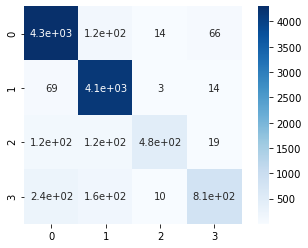

In [23]:
sns.heatmap(cm_train, square=True, cbar=True, annot=True, cmap='Blues')

<AxesSubplot:>

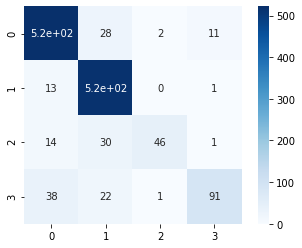

In [24]:
sns.heatmap(cm_test, square=True, cbar=True, annot=True, cmap='Blues')

In [25]:
labels = lg.classes_
precision = precision_score(y_true=Y_test, y_pred=Y_test_pred, average=None, labels=['b', 'e', 't', 'm'])

print('適合率 : ')
for i, category in enumerate(labels):
    print(category+' : {:.4f}'.format(precision[i]))
print('マクロ平均 : {:.4f}'.format(precision_score(y_true=Y_test, y_pred=Y_test_pred, average='macro', labels=['b', 'e', 't', 'm'])))
print('マイクロ平均 : {:.4f}'.format(precision_score(y_true=Y_test, y_pred=Y_test_pred, average='micro', labels=['b', 'e', 't', 'm'])))

適合率 : 
b : 0.8893
e : 0.8658
m : 0.8750
t : 0.9388
マクロ平均 : 0.8922
マイクロ平均 : 0.8795


In [26]:
recall = recall_score(y_true=Y_test, y_pred=Y_test_pred, average=None, labels=['b', 'e', 't', 'm'])

print('再現率 : ')
for i, category in enumerate(labels):
    print(category+' : {:.4f}'.format(recall[i]))
print('マクロ平均 : {:.4f}'.format(recall_score(y_true=Y_test, y_pred=Y_test_pred, average='macro', labels=['b', 'e', 't', 'm'])))
print('マイクロ平均 : {:.4f}'.format(recall_score(y_true=Y_test, y_pred=Y_test_pred, average='micro', labels=['b', 'e', 't', 'm'])))

再現率 : 
b : 0.9272
e : 0.9736
m : 0.5987
t : 0.5055
マクロ平均 : 0.7512
マイクロ平均 : 0.8795


In [27]:
f1 = f1_score(y_true=Y_test, y_pred=Y_test_pred, average=None, labels=['b', 'e', 't', 'm'])

print('F1スコア : ')
for i, category in enumerate(labels):
    print(category+' : {:.4f}'.format(f1[i]))
print('マクロ平均 : {:.4f}'.format(f1_score(y_true=Y_test, y_pred=Y_test_pred, average='macro', labels=['b', 'e', 't', 'm'])))
print('マイクロ平均 : {:.4f}'.format(f1_score(y_true=Y_test, y_pred=Y_test_pred, average='micro', labels=['b', 'e', 't', 'm'])))

F1スコア : 
b : 0.9078
e : 0.9165
m : 0.7109
t : 0.6571
マクロ平均 : 0.7981
マイクロ平均 : 0.8795


In [28]:
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(lg.classes_, lg.coef_):
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
  display(pd.concat([best10, worst10], axis=0))
  print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,bank,fed,ecb,stocks,obamacare,oil,ukraine,euro,china,yellen
重要度下位,video,her,the,ebola,she,could,star,virus,mers,my




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,chris,kardashian,her,movie,she,paul,kim,miley,film,he
重要度下位,update,us,google,study,ceo,risk,says,data,gm,billion




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,study,cancer,mers,drug,fda,medical,doctors,outbreak,cases
重要度下位,ceo,facebook,gm,bank,deal,sales,apple,climate,twitter,he




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,apple,climate,microsoft,tmobile,tesla,gm,fcc,googles
重要度下位,her,drug,stocks,cancer,american,percent,fed,ukraine,at,before


In [29]:
from tqdm import tqdm

In [30]:
result = []
for C in tqdm(np.logspace(-5, 5, 10, base=10)):
    lg = LogisticRegression(random_state=123, max_iter=10000, C=C)
    lg.fit(X_train, train['CATEGORY'])
    
    train_pred = score_lg(lg, X_train)
    valid_pred = score_lg(lg, X_valid)
    test_pred = score_lg(lg, X_test)
     
    acc_train = accuracy_score(y_true=train['CATEGORY'], y_pred=train_pred[1])
    acc_valid = accuracy_score(y_true=valid['CATEGORY'], y_pred=valid_pred[1])
    acc_test = accuracy_score(y_true=test['CATEGORY'], y_pred=test_pred[1])
    
    result.append([C, acc_train, acc_valid, acc_test]) 

100%|██████████| 10/10 [06:53<00:00, 41.36s/it] 


In [31]:
import matplotlib.pyplot as plt

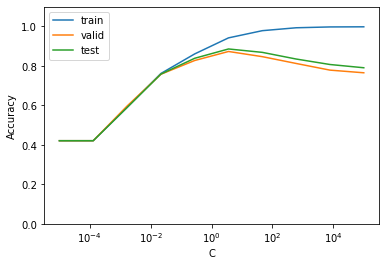

In [32]:
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

In [33]:
import optuna

class Objective:
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ハイパーパラメータの設定
        params = {
            # 最適化アルゴリズムを指定
            'solver' : trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
            # 正則化の強さを指定（0.0001から10まで）
            'C': trial.suggest_loguniform('C', 0.0001, 10),
            # 最大反復回数（＊ソルバーが収束するまで）
            'max_iter': trial.suggest_int('max_iter', 100, 100000)
            }

        lg = LogisticRegression(**params)
        lg.fit(self.X, self.y)
        
        valid_pred = score_lg(lg, X_valid)
        acc_valid = accuracy_score(y_true=valid['CATEGORY'], y_pred=valid_pred[1])
        
        return acc_valid

In [34]:
# ハイパーパラメータの探索
objective = Objective(X_train, train['CATEGORY'])
study = optuna.create_study(direction='maximize') # 最大化
study.optimize(objective, timeout=3600)

# ベストパラメータを出力
print('params:', study.best_params)

[I 2022-04-25 14:04:31,123] A new study created in memory with name: no-name-12ad46cf-ce1a-412b-9ac7-234794b7ecea
[I 2022-04-25 14:04:36,921] Trial 0 finished with value: 0.8720059880239521 and parameters: {'solver': 'lbfgs', 'C': 1.4211099307133992, 'max_iter': 81581}. Best is trial 0 with value: 0.8720059880239521.
[I 2022-04-25 14:04:47,647] Trial 1 finished with value: 0.8038922155688623 and parameters: {'solver': 'saga', 'C': 0.1573707493764093, 'max_iter': 51384}. Best is trial 0 with value: 0.8720059880239521.
[I 2022-04-25 14:04:51,113] Trial 2 finished with value: 0.8263473053892215 and parameters: {'solver': 'newton-cg', 'C': 0.2762680042871743, 'max_iter': 83337}. Best is trial 0 with value: 0.8720059880239521.
[I 2022-04-25 14:04:57,712] Trial 3 finished with value: 0.8682634730538922 and parameters: {'solver': 'newton-cg', 'C': 9.273356504195789, 'max_iter': 14515}. Best is trial 0 with value: 0.8720059880239521.
[I 2022-04-25 14:05:15,022] Trial 4 finished with value: 0.8

[I 2022-04-25 14:11:57,004] Trial 39 finished with value: 0.8720059880239521 and parameters: {'solver': 'newton-cg', 'C': 1.7966116739184714, 'max_iter': 55206}. Best is trial 11 with value: 0.875.
[I 2022-04-25 14:11:59,979] Trial 40 finished with value: 0.8241017964071856 and parameters: {'solver': 'lbfgs', 'C': 0.23073579122074866, 'max_iter': 80135}. Best is trial 11 with value: 0.875.
[I 2022-04-25 14:12:13,825] Trial 41 finished with value: 0.875 and parameters: {'solver': 'saga', 'C': 3.0083606315933173, 'max_iter': 85574}. Best is trial 11 with value: 0.875.
[I 2022-04-25 14:12:33,948] Trial 42 finished with value: 0.8727544910179641 and parameters: {'solver': 'saga', 'C': 6.142464603280651, 'max_iter': 95180}. Best is trial 11 with value: 0.875.
[I 2022-04-25 14:12:44,955] Trial 43 finished with value: 0.8517964071856288 and parameters: {'solver': 'saga', 'C': 0.5146014354017912, 'max_iter': 86308}. Best is trial 11 with value: 0.875.
[I 2022-04-25 14:13:22,245] Trial 44 finis

[I 2022-04-25 14:20:06,255] Trial 79 finished with value: 0.874251497005988 and parameters: {'solver': 'lbfgs', 'C': 3.1939967798338382, 'max_iter': 986}. Best is trial 69 with value: 0.875748502994012.
[I 2022-04-25 14:20:10,583] Trial 80 finished with value: 0.8540419161676647 and parameters: {'solver': 'lbfgs', 'C': 0.5908177538968766, 'max_iter': 26509}. Best is trial 69 with value: 0.875748502994012.
[I 2022-04-25 14:20:11,179] Trial 81 finished with value: 0.4214071856287425 and parameters: {'solver': 'lbfgs', 'C': 0.0003342024686541596, 'max_iter': 42103}. Best is trial 69 with value: 0.875748502994012.
[I 2022-04-25 14:20:17,972] Trial 82 finished with value: 0.874251497005988 and parameters: {'solver': 'lbfgs', 'C': 2.3204157229422457, 'max_iter': 93127}. Best is trial 69 with value: 0.875748502994012.
[I 2022-04-25 14:20:25,981] Trial 83 finished with value: 0.8727544910179641 and parameters: {'solver': 'lbfgs', 'C': 3.4026706935605846, 'max_iter': 99967}. Best is trial 69 wi

[I 2022-04-25 14:24:24,547] Trial 117 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 6.2318069453719, 'max_iter': 93927}. Best is trial 107 with value: 0.8787425149700598.
[I 2022-04-25 14:24:24,976] Trial 118 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 6.130604159680217, 'max_iter': 91542}. Best is trial 107 with value: 0.8787425149700598.
[I 2022-04-25 14:24:25,410] Trial 119 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 8.955214123608537, 'max_iter': 91247}. Best is trial 107 with value: 0.8787425149700598.
[I 2022-04-25 14:24:25,848] Trial 120 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 7.954133709686597, 'max_iter': 93335}. Best is trial 120 with value: 0.8794910179640718.
[I 2022-04-25 14:24:26,286] Trial 121 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 8.660901955110742, 'max_iter': 

[I 2022-04-25 14:24:40,650] Trial 154 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.818240357054431, 'max_iter': 83331}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:24:41,078] Trial 155 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 6.426691535780205, 'max_iter': 84507}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:24:41,520] Trial 156 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 9.708014239800276, 'max_iter': 83508}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:24:41,962] Trial 157 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 9.860614701934532, 'max_iter': 80239}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:24:42,381] Trial 158 finished with value: 0.8772455089820359 and parameters: {'solver': 'liblinear', 'C': 4.640066765626679, 'max_iter'

[I 2022-04-25 14:25:02,872] Trial 191 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.584289676029054, 'max_iter': 84115}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:25:03,305] Trial 192 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.84118714872426, 'max_iter': 84457}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:25:03,723] Trial 193 finished with value: 0.8779940119760479 and parameters: {'solver': 'liblinear', 'C': 3.906869962118098, 'max_iter': 66196}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:25:04,182] Trial 194 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 6.3361863557747515, 'max_iter': 84188}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:25:04,610] Trial 195 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 5.842798304327388, 'max_iter'

[I 2022-04-25 14:25:24,300] Trial 228 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.7139663198605914, 'max_iter': 86107}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:25:24,731] Trial 229 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 5.563974016893727, 'max_iter': 77019}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:25:25,148] Trial 230 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 3.7510517443961495, 'max_iter': 81315}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:25:25,585] Trial 231 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.8629574343790525, 'max_iter': 85965}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:25:26,018] Trial 232 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 6.457503429016997, 'max_it

[I 2022-04-25 14:26:36,887] Trial 265 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 8.382645373417873, 'max_iter': 77131}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:26:37,324] Trial 266 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.965518811270562, 'max_iter': 89780}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:26:37,766] Trial 267 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 9.931612380600216, 'max_iter': 80689}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:26:38,181] Trial 268 finished with value: 0.8802395209580839 and parameters: {'solver': 'liblinear', 'C': 3.7192741876227, 'max_iter': 85318}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:26:38,601] Trial 269 finished with value: 0.8772455089820359 and parameters: {'solver': 'liblinear', 'C': 4.713481842863639, 'max_iter': 

[I 2022-04-25 14:27:12,249] Trial 302 finished with value: 0.8772455089820359 and parameters: {'solver': 'liblinear', 'C': 4.702040231244371, 'max_iter': 85076}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:27:12,685] Trial 303 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.973187400255937, 'max_iter': 84127}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:27:13,112] Trial 304 finished with value: 0.8779940119760479 and parameters: {'solver': 'liblinear', 'C': 5.646242918783308, 'max_iter': 86843}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:27:13,548] Trial 305 finished with value: 0.8802395209580839 and parameters: {'solver': 'liblinear', 'C': 8.683689272287651, 'max_iter': 82803}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:27:13,968] Trial 306 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 4.25988340970538, 'max_iter':

[I 2022-04-25 14:28:40,366] Trial 339 finished with value: 0.8802395209580839 and parameters: {'solver': 'liblinear', 'C': 8.65069393815473, 'max_iter': 82782}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:28:40,799] Trial 340 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 5.410495306978685, 'max_iter': 81799}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:28:41,230] Trial 341 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 6.314409960176441, 'max_iter': 37833}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:28:41,690] Trial 342 finished with value: 0.8802395209580839 and parameters: {'solver': 'liblinear', 'C': 6.53364664615775, 'max_iter': 84218}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:28:47,691] Trial 343 finished with value: 0.875 and parameters: {'solver': 'newton-cg', 'C': 4.307316034559126, 'max_iter': 78392}. Best 

[I 2022-04-25 14:31:12,575] Trial 376 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 5.15380690269437, 'max_iter': 92531}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:31:13,018] Trial 377 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 9.991707258713506, 'max_iter': 79574}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:31:13,456] Trial 378 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 7.798134939532958, 'max_iter': 87606}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:31:13,892] Trial 379 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.9097739375004235, 'max_iter': 86463}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:32:30,408] Trial 380 finished with value: 0.8735029940119761 and parameters: {'solver': 'sag', 'C': 5.7766093453411305, 'max_iter': 841

[I 2022-04-25 14:34:38,560] Trial 413 finished with value: 0.8772455089820359 and parameters: {'solver': 'liblinear', 'C': 4.71921674742122, 'max_iter': 64171}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:34:38,993] Trial 414 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 6.278157195544666, 'max_iter': 89348}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:34:39,416] Trial 415 finished with value: 0.8772455089820359 and parameters: {'solver': 'liblinear', 'C': 4.926921373636161, 'max_iter': 94365}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:34:39,835] Trial 416 finished with value: 0.8802395209580839 and parameters: {'solver': 'liblinear', 'C': 3.718657331308575, 'max_iter': 75669}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:34:40,275] Trial 417 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 8.237219027717318, 'max_iter':

[I 2022-04-25 14:37:18,557] Trial 450 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 9.931615091205407, 'max_iter': 83183}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:37:18,984] Trial 451 finished with value: 0.8772455089820359 and parameters: {'solver': 'liblinear', 'C': 4.91648588652642, 'max_iter': 78339}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:37:19,428] Trial 452 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 9.946789160486166, 'max_iter': 84636}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:37:19,862] Trial 453 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 5.874520667406592, 'max_iter': 91382}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:37:36,160] Trial 454 finished with value: 0.874251497005988 and parameters: {'solver': 'saga', 'C': 3.9408603081413833, 'max_iter': 7432

[I 2022-04-25 14:40:01,979] Trial 487 finished with value: 0.6317365269461078 and parameters: {'solver': 'liblinear', 'C': 0.0030607301896749925, 'max_iter': 85930}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:40:02,422] Trial 488 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 9.88072913566556, 'max_iter': 89084}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:40:02,862] Trial 489 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 8.103125996892093, 'max_iter': 76498}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:40:12,174] Trial 490 finished with value: 0.8735029940119761 and parameters: {'solver': 'lbfgs', 'C': 5.7306121782882204, 'max_iter': 88792}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:40:12,699] Trial 491 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 9.982120484417194, 'max_iter'

[I 2022-04-25 14:41:57,264] Trial 524 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 9.941052360771673, 'max_iter': 86198}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:41:57,684] Trial 525 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 3.276775099382387, 'max_iter': 84420}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:41:58,105] Trial 526 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 4.342534940748805, 'max_iter': 72526}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:41:58,532] Trial 527 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 5.281038442462444, 'max_iter': 83013}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:41:58,974] Trial 528 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 8.303451337890557, 'max_iter'

[I 2022-04-25 14:43:36,577] Trial 561 finished with value: 0.8772455089820359 and parameters: {'solver': 'liblinear', 'C': 4.769420551464213, 'max_iter': 87215}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:43:37,015] Trial 562 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.789377099821446, 'max_iter': 80194}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:43:42,651] Trial 563 finished with value: 0.8735029940119761 and parameters: {'solver': 'newton-cg', 'C': 4.0419737659681045, 'max_iter': 89325}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:43:43,149] Trial 564 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 5.69183999666654, 'max_iter': 88640}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:43:43,571] Trial 565 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 3.486311166732083, 'max_iter'

[I 2022-04-25 14:45:32,810] Trial 598 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 3.8290870337003113, 'max_iter': 74738}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:45:33,252] Trial 599 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 7.954309777348196, 'max_iter': 82045}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:45:33,693] Trial 600 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 7.16501083044512, 'max_iter': 81221}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:45:34,119] Trial 601 finished with value: 0.8779940119760479 and parameters: {'solver': 'liblinear', 'C': 4.538194028004858, 'max_iter': 84215}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:45:34,546] Trial 602 finished with value: 0.8772455089820359 and parameters: {'solver': 'liblinear', 'C': 4.5595796775090776, 'max_iter

[I 2022-04-25 14:47:35,613] Trial 635 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 7.066895983794352, 'max_iter': 92221}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:47:36,041] Trial 636 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 4.486900878417175, 'max_iter': 77014}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:47:36,475] Trial 637 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 5.6227261391085746, 'max_iter': 66208}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:47:36,919] Trial 638 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 9.959923584896922, 'max_iter': 85555}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:47:37,353] Trial 639 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 5.673638065429361, 'max_iter

[I 2022-04-25 14:51:20,964] Trial 672 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 6.48860925233071, 'max_iter': 95760}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:51:21,391] Trial 673 finished with value: 0.8772455089820359 and parameters: {'solver': 'liblinear', 'C': 4.559028022384638, 'max_iter': 78447}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:51:21,835] Trial 674 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 8.235619338234217, 'max_iter': 87623}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:51:22,277] Trial 675 finished with value: 0.8802395209580839 and parameters: {'solver': 'liblinear', 'C': 7.283693864078691, 'max_iter': 94491}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:51:22,718] Trial 676 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 8.272367813252568, 'max_iter':

[I 2022-04-25 14:53:29,628] Trial 709 finished with value: 0.8727544910179641 and parameters: {'solver': 'lbfgs', 'C': 6.04410519608213, 'max_iter': 80152}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:53:30,142] Trial 710 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 7.38799678001609, 'max_iter': 64062}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:53:30,586] Trial 711 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 8.381918095212926, 'max_iter': 79584}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:53:31,009] Trial 712 finished with value: 0.8772455089820359 and parameters: {'solver': 'liblinear', 'C': 4.771656060205072, 'max_iter': 91427}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:53:31,456] Trial 713 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 9.9469403686552, 'max_iter': 57595}

[I 2022-04-25 14:55:03,117] Trial 746 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.729791110228262, 'max_iter': 86985}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:55:03,540] Trial 747 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 3.5958098206494236, 'max_iter': 67173}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:55:03,970] Trial 748 finished with value: 0.8772455089820359 and parameters: {'solver': 'liblinear', 'C': 4.856581869994568, 'max_iter': 99524}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:55:10,151] Trial 749 finished with value: 0.8682634730538922 and parameters: {'solver': 'newton-cg', 'C': 9.834303746898298, 'max_iter': 89694}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:55:10,655] Trial 750 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 5.601267609451988, 'max_iter

[I 2022-04-25 14:56:17,641] Trial 783 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 3.4045516275020766, 'max_iter': 64866}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:58:19,946] Trial 784 finished with value: 0.8682634730538922 and parameters: {'solver': 'sag', 'C': 9.884012708011907, 'max_iter': 82927}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:58:20,416] Trial 785 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 8.236769219063502, 'max_iter': 88869}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:58:20,855] Trial 786 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 5.89644478416468, 'max_iter': 91184}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 14:58:21,285] Trial 787 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 4.425670563068586, 'max_iter': 7699

[I 2022-04-25 15:01:27,525] Trial 820 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.982100719387145, 'max_iter': 64822}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 15:01:27,974] Trial 821 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 8.332633540445691, 'max_iter': 83278}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 15:01:28,400] Trial 822 finished with value: 0.8772455089820359 and parameters: {'solver': 'liblinear', 'C': 4.764177749973781, 'max_iter': 83607}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 15:01:28,847] Trial 823 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 7.604848802044105, 'max_iter': 97186}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 15:01:29,292] Trial 824 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.842163300963173, 'max_iter'

[I 2022-04-25 15:03:30,993] Trial 857 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 6.2802360449891514, 'max_iter': 95735}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 15:03:31,435] Trial 858 finished with value: 0.8809880239520959 and parameters: {'solver': 'liblinear', 'C': 6.734624722900572, 'max_iter': 64618}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 15:03:31,883] Trial 859 finished with value: 0.8787425149700598 and parameters: {'solver': 'liblinear', 'C': 9.942610200416967, 'max_iter': 85537}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 15:03:40,857] Trial 860 finished with value: 0.8735029940119761 and parameters: {'solver': 'lbfgs', 'C': 5.126875528657002, 'max_iter': 87493}. Best is trial 133 with value: 0.8809880239520959.
[I 2022-04-25 15:03:41,384] Trial 861 finished with value: 0.8794910179640718 and parameters: {'solver': 'liblinear', 'C': 7.566829244136376, 'max_iter': 6

params: {'solver': 'liblinear', 'C': 7.121206744012977, 'max_iter': 81135}


In [35]:
solver = study.best_params['solver']
C = study.best_params['C']
max_iter = study.best_params['max_iter']

In [36]:
lg = LogisticRegression(random_state=123, max_iter=max_iter, C=C, solver=solver)
lg.fit(X_train, train['CATEGORY'])

LogisticRegression(C=7.121206744012977, max_iter=81135, random_state=123,
                   solver='liblinear')

In [37]:
train_pred = score_lg(lg, X_train)
valid_pred = score_lg(lg, X_valid)
test_pred = score_lg(lg, X_test)

acc_train = accuracy_score(y_true=train['CATEGORY'], y_pred=train_pred[1])
acc_valid = accuracy_score(y_true=valid['CATEGORY'], y_pred=valid_pred[1])
acc_test = accuracy_score(y_true=test['CATEGORY'], y_pred=test_pred[1])

In [38]:
acc_t

0.9425308873081243

In [ ]:
print('正解率(訓練データ) : ',accuracy_score(y_true=Y_train, y_pred=Y_train_pred))